In [1]:
# PASTE THIS TO THE FIRST CELL OF THE NOTEBOOK IN ORDER TO HAVE WORKING IMPORTS
import sys
import os
current_dir = os.getcwd()
parent_parent_dir = os.path.abspath(os.path.join(current_dir, '../..')) # tweak so that you get the root project folder

sys.path.append(parent_parent_dir)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from src.features.get_x_y_tuples import * 
from sklearn.cluster import OPTICS
from src.models.clustering_optimization.optimize_optics import *
from matplotlib.gridspec import GridSpec
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles

In [3]:
# 1. load into dataframe
df_k729_2022_cuid = pd.read_csv('../../data/processed/k729_2022_cuid_lat_lon.csv')
df_k729_2022_cuid_grouped = pd.read_csv('../../data/processed/k729_2022_cuid_grouped_lat_lon.csv')
# 2. transform values to numbers
df_k729_2022_cuid_grouped['x'] = df_k729_2022_cuid_grouped['x'].apply(lambda x: ast.literal_eval(x))
df_k729_2022_cuid_grouped['y'] = df_k729_2022_cuid_grouped['y'].apply(lambda y: ast.literal_eval(y))

# 3. create tuple lists
list_k729_2022_x_y_tuples = get_x_y_tuple_list(df_k729_2022_cuid_grouped, ['x','y'])


In [4]:
from src.features.get_first_and_last_x_y_coordinates import *
from src.features.get_first_coordinates import get_first_x_y_coordinates
from src.features.get_last_coordinates import get_last_x_y_coordinates

first_last_x_coords, first_last_y_coords = get_first_and_last_x_y_coordinates(list_k729_2022_x_y_tuples)


In [5]:
x_width = max(first_last_x_coords) - min(first_last_x_coords)
y_width = max(first_last_y_coords) - min(first_last_y_coords)

# make the penalty range between 10% and 90% of the width
x_range = (min(first_last_x_coords) + 0.1*x_width, max(first_last_x_coords) - 0.1*x_width)
y_range =  (min(first_last_y_coords) + 0.1*y_width, max(first_last_y_coords) - 0.1*y_width)

In [6]:
cluster_method = 'dbscan'
metric='euclidean'

In [7]:
x_min, x_max = df_k729_2022_cuid['x'].min(), df_k729_2022_cuid['x'].max()
y_min, y_max = df_k729_2022_cuid['y'].min(), df_k729_2022_cuid['y'].max()
x_width = x_max - x_min
y_width = y_max - y_min

spectrum_factor = 0.3

# make the penalty range between 10% and 90% of the width
x_range = [x_min + spectrum_factor * x_width, x_max - spectrum_factor * x_width]
y_range = [y_min + spectrum_factor * y_width, y_max - spectrum_factor * y_width]

# OPTIMIZATION EDGE ADJUSTED MEDIOIDS

In [ ]:
eps_range = np.arange(0.1, 5, 0.1)
min_samples_range = np.arange(2, 30, 1)
optimization_results = optimize_optics_mediod_edge_adjusted_medioids(np.array([first_last_x_coords, first_last_y_coords]).T, eps_range, min_samples_range, x_range, y_range, cluster_method='dbscan', metric='euclidean')
print(optimization_results)

In [8]:
# take the the optimized optics parameters for each score and cluster the start and end points
score_optimized_silhouette = optimization_results['silhouette']['score']
max_eps_optimized_silhouette = optimization_results['silhouette']['epsilon']
min_samples_optimized_silhouette = optimization_results['silhouette']['min_samples']

score_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['score']
max_eps_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['epsilon']
min_samples_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['min_samples']

score_optimized_davies_bouldin = optimization_results['davies_bouldin']['score']
max_eps_optimized_davies_bouldin = optimization_results['davies_bouldin']['epsilon']
min_samples_optimized_davies_bouldin = optimization_results['davies_bouldin']['min_samples']

optics_clustering_start_end_silhouette = OPTICS(min_samples=min_samples_optimized_silhouette,
                            max_eps=max_eps_optimized_silhouette,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_calinski_harabasz = OPTICS(min_samples=min_samples_optimized_calinski_harabasz,
                            max_eps=max_eps_optimized_calinski_harabasz,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_davies_bouldin = OPTICS(min_samples=min_samples_optimized_davies_bouldin,
                            max_eps=max_eps_optimized_davies_bouldin,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)


In [9]:
# plot the optimized optics cluster with the silhouette parameters

point_colors_start_end_silhouette_optimized, colors_start_end_silhouette_optimized = get_cluster_colors(optics_clustering_start_end_silhouette.labels_)
legend_handles_start_end_silhouette_optimized = get_cluster_legend_handles(colors_start_end_silhouette_optimized, optics_clustering_start_end_silhouette.labels_)
metrics_description_optics_silhouette_optimized = f'min samples: {min_samples_optimized_silhouette}      max eps: {max_eps_optimized_silhouette}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("clustermethod", r"$\bf{clustermethod}$")

# plot the optimized optics cluster with the calinski harabasz parameters
point_colors_start_end_calinski_harabasz_optimized, colors_start_end_calinski_harabasz_optimized = get_cluster_colors(optics_clustering_start_end_calinski_harabasz.labels_)
legend_handles_start_end_calinski_harabasz_optimized = get_cluster_legend_handles(colors_start_end_calinski_harabasz_optimized, optics_clustering_start_end_calinski_harabasz.labels_)
metrics_description_optics_calinski_harabasz_optimized = f'min samples: {min_samples_optimized_calinski_harabasz}      max eps: {max_eps_optimized_calinski_harabasz}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("clustermethod", r"$\bf{clustermethod}$")

# plot the optimized optics cluster with the davies bouldin parameters
point_colors_start_end_davies_bouldin_optimized, colors_start_end_davies_bouldin_optimized = get_cluster_colors(optics_clustering_start_end_davies_bouldin.labels_)
legend_handles_start_end_davies_bouldin_optimized = get_cluster_legend_handles(colors_start_end_davies_bouldin_optimized, optics_clustering_start_end_davies_bouldin.labels_)
metrics_description_optics_davies_bouldin_optimized = f'min samples: {min_samples_optimized_davies_bouldin}      max eps: {max_eps_optimized_davies_bouldin}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("clustermethod", r"$\bf{clustermethod}$")


In [10]:
# create a text where in each row the optimized parameters are shown
text = f'Silhouette Optimized: \n'
text += f'Score: {score_optimized_silhouette}       '
text += f'EPS: {max_eps_optimized_silhouette}       '
text += f'Min Samples: {min_samples_optimized_silhouette}\n'
text += f'Calinski Harabasz Optimized: \n'
text += f'Score: {score_optimized_calinski_harabasz}       '
text += f'EPS: {max_eps_optimized_calinski_harabasz}       '
text += f'Min Samples: {min_samples_optimized_calinski_harabasz}\n'
text += f'Davies-Bouldin Optimized: \n'
text += f'Score: {score_optimized_davies_bouldin}       '
text += f'EPS: {max_eps_optimized_davies_bouldin}       '
text += f'Min Samples: {min_samples_optimized_davies_bouldin}\n\n'
text += f'Penalized for clusters inside the penalty range: \n'
text += f'Penalty Range: {x_range} x {y_range}\n'

# make text bold
text = text.replace("Score", r"$\bf{Score}$")
text = text.replace("EPS", r"$\bf{EPS}$")
text = text.replace("Min Samples", r"$\bf{Min \; Samples}$")
text = text.replace("Silhouette Optimized", r"$\bf{Silhouette \; Optimized}$")
text = text.replace("Calinski Harabasz Optimized", r"$\bf{Calinski \; Harabasz \; Optimized}$")
text = text.replace("Davies-Bouldin Optimized", r"$\bf{Davies-Bouldin \; Optimized}$")
text = text.replace("Penalized for clusters inside the penalty range", r"$\bf{Penalized \; for \; clusters \; inside \; the \; penalty \; range}$")
text = text.replace("Penalty Range", r"$\bf{Penalty \; Range}$")
# make titles bold

metrics_description_optimzation = text

In [ ]:


fig = plt.figure(figsize=(19, 7))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) 
ax1.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_silhouette_optimized)
ax1.set_title(f'Silhouette optimized clustering', fontsize=15)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.legend(handles=legend_handles_start_end_silhouette_optimized)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_calinski_harabasz_optimized)
ax2.set_title(f'Calinski-Harabasz optimized clustering', fontsize=15)
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.legend(handles=legend_handles_start_end_calinski_harabasz_optimized)

# Create the bottom right plot
ax3 = fig.add_subplot(gs[0, 2])  # Bottom right
ax3.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_davies_bouldin_optimized)
# ax3.text(0.5, 1.4, "End Point Clusters", fontsize=16, ha='center', transform=ax3.transAxes)
ax3.set_title(f'Davies-Bouldin optimized clustering', fontsize=15)
ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.legend(handles=legend_handles_start_end_davies_bouldin_optimized)

props = dict(boxstyle='square', facecolor='green', alpha=0.15)
fig.text(0.012,-0.3,f'{metrics_description_optimzation}', fontsize=12, bbox=props)
plt.suptitle('Optimized clustering 1 for certain scores', fontsize=20)

# Display the plots
plt.tight_layout()
plt.show()

# OPTIMIZATION EDGE ADJUSTED CLUSTER MEMBERS

In [13]:
cluster_method = 'dbscan'
metric='euclidean'

In [ ]:
from src.models.clustering_optimization.optimize_optics import *
penalty_factor = 5
eps_range = np.arange(0.1, 5, 0.1)
min_samples_range = np.arange(2, 30, 1)
optimization_results = optimize_optics_mediod_edge_adjusted_cluster_members(np.array([first_last_x_coords, first_last_y_coords]).T, eps_range, min_samples_range, x_range, y_range, penalty=penalty_factor, cluster_method='dbscan', metric='euclidean')
print(optimization_results)

In [15]:
# take the the optimized optics parameters for each score and cluster the start and end points
score_optimized_silhouette = optimization_results['silhouette']['score']
max_eps_optimized_silhouette = optimization_results['silhouette']['epsilon']
min_samples_optimized_silhouette = optimization_results['silhouette']['min_samples']

score_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['score']
max_eps_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['epsilon']
min_samples_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['min_samples']

score_optimized_davies_bouldin = optimization_results['davies_bouldin']['score']
max_eps_optimized_davies_bouldin = optimization_results['davies_bouldin']['epsilon']
min_samples_optimized_davies_bouldin = optimization_results['davies_bouldin']['min_samples']

optics_clustering_start_end_silhouette = OPTICS(min_samples=min_samples_optimized_silhouette,
                            max_eps=max_eps_optimized_silhouette,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_calinski_harabasz = OPTICS(min_samples=min_samples_optimized_calinski_harabasz,
                            max_eps=max_eps_optimized_calinski_harabasz,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_davies_bouldin = OPTICS(min_samples=min_samples_optimized_davies_bouldin,
                            max_eps=max_eps_optimized_davies_bouldin,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)


In [16]:
# plot the optimized optics cluster with the silhouette parameters
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles


point_colors_start_end_silhouette_optimized, colors_start_end_silhouette_optimized = get_cluster_colors(optics_clustering_start_end_silhouette.labels_)
legend_handles_start_end_silhouette_optimized = get_cluster_legend_handles(colors_start_end_silhouette_optimized, optics_clustering_start_end_silhouette.labels_)
metrics_description_optics_silhouette_optimized = f'min samples: {min_samples_optimized_silhouette}      max eps: {max_eps_optimized_silhouette}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_silhouette_optimized = metrics_description_optics_silhouette_optimized.replace("clustermethod", r"$\bf{clustermethod}$")

# plot the optimized optics cluster with the calinski harabasz parameters
point_colors_start_end_calinski_harabasz_optimized, colors_start_end_calinski_harabasz_optimized = get_cluster_colors(optics_clustering_start_end_calinski_harabasz.labels_)
legend_handles_start_end_calinski_harabasz_optimized = get_cluster_legend_handles(colors_start_end_calinski_harabasz_optimized, optics_clustering_start_end_calinski_harabasz.labels_)
metrics_description_optics_calinski_harabasz_optimized = f'min samples: {min_samples_optimized_calinski_harabasz}      max eps: {max_eps_optimized_calinski_harabasz}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_calinski_harabasz_optimized = metrics_description_optics_calinski_harabasz_optimized.replace("clustermethod", r"$\bf{clustermethod}$")

# plot the optimized optics cluster with the davies bouldin parameters
point_colors_start_end_davies_bouldin_optimized, colors_start_end_davies_bouldin_optimized = get_cluster_colors(optics_clustering_start_end_davies_bouldin.labels_)
legend_handles_start_end_davies_bouldin_optimized = get_cluster_legend_handles(colors_start_end_davies_bouldin_optimized, optics_clustering_start_end_davies_bouldin.labels_)
metrics_description_optics_davies_bouldin_optimized = f'min samples: {min_samples_optimized_davies_bouldin}      max eps: {max_eps_optimized_davies_bouldin}      metric: {metric}        clustermethod: {cluster_method}'
# make the f string parts of the above string italic to use in a plot
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("min samples", r"$\bf{min \; samples}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("max eps", r"$\bf{max \; \epsilon}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("metric", r"$\bf{metric}$")
metrics_description_optics_davies_bouldin_optimized = metrics_description_optics_davies_bouldin_optimized.replace("clustermethod", r"$\bf{clustermethod}$")


In [17]:
# create a text where in each row the optimized parameters are shown
text = f'Silhouette Optimized: \n'
text += f'Score: {score_optimized_silhouette}       '
text += f'EPS: {max_eps_optimized_silhouette}       '
text += f'Min Samples: {min_samples_optimized_silhouette}\n'
text += f'Calinski Harabasz Optimized: \n'
text += f'Score: {score_optimized_calinski_harabasz}       '
text += f'EPS: {max_eps_optimized_calinski_harabasz}       '
text += f'Min Samples: {min_samples_optimized_calinski_harabasz}\n'
text += f'Davies-Bouldin Optimized: \n'
text += f'Score: {score_optimized_davies_bouldin}       '
text += f'EPS: {max_eps_optimized_davies_bouldin}       '
text += f'Min Samples: {min_samples_optimized_davies_bouldin}\n\n'
text += f'Penalized for clusters inside the penalty range: \n'
text += f'Penalty Range: {x_range} x {y_range}\n'
text += f'Penalty Score: {penalty_factor}'

# make text bold
text = text.replace("Score", r"$\bf{Score}$")
text = text.replace("EPS", r"$\bf{EPS}$")
text = text.replace("Min Samples", r"$\bf{Min \; Samples}$")
text = text.replace("Silhouette Optimized", r"$\bf{Silhouette \; Optimized}$")
text = text.replace("Calinski Harabasz Optimized", r"$\bf{Calinski \; Harabasz \; Optimized}$")
text = text.replace("Davies-Bouldin Optimized", r"$\bf{Davies-Bouldin \; Optimized}$")
text = text.replace("Penalized for clusters inside the penalty range", r"$\bf{Penalized \; for \; clusters \; inside \; the \; penalty \; range}$")
text = text.replace("Penalty Range", r"$\bf{Penalty \; Range}$")
text = text.replace("Penalty Score", r"$\bf{Penalty \; Score}$")
# make titles bold

metrics_description_optimzation = text

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(19, 7))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) 
ax1.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_silhouette_optimized)
ax1.set_title(f'Silhouette optimized clustering', fontsize=15)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.legend(handles=legend_handles_start_end_silhouette_optimized)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_calinski_harabasz_optimized)
ax2.set_title(f'Calinski-Harabasz optimized clustering', fontsize=15)
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.legend(handles=legend_handles_start_end_calinski_harabasz_optimized)

# Create the bottom right plot
ax3 = fig.add_subplot(gs[0, 2])  # Bottom right
ax3.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_davies_bouldin_optimized)
# ax3.text(0.5, 1.4, "End Point Clusters", fontsize=16, ha='center', transform=ax3.transAxes)
ax3.set_title(f'Davies-Bouldin optimized clustering', fontsize=15)
ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.legend(handles=legend_handles_start_end_davies_bouldin_optimized)

props = dict(boxstyle='square', facecolor='green', alpha=0.15)
fig.text(0.012,-0.3,f'{metrics_description_optimzation}', fontsize=12, bbox=props)
plt.suptitle('Optimized clustering 1 for certain scores', fontsize=20)

# Display the plots
plt.tight_layout()
plt.show()

# OPTIMIZATION EDGE ADJUSTED CLUSTER MEMBERS ACCUMULATED

In [8]:
cluster_method = 'dbscan'
metric='euclidean'

In [ ]:
from src.models.clustering_optimization.optimize_optics import *
penalty_factor = 1000000000
eps_range = np.arange(0.1, 5, 0.1)
min_samples_range = np.arange(2, 30, 1)
optimization_results = optimize_optics_mediod_edge_adjusted_cluster_members_accumulating(np.array([first_last_x_coords, first_last_y_coords]).T, eps_range, min_samples_range, x_range, y_range, penalty=penalty_factor, cluster_method='dbscan', metric='euclidean')
print(optimization_results)

In [11]:
# take the the optimized optics parameters for each score and cluster the start and end points
score_optimized_silhouette = optimization_results['silhouette']['score']
max_eps_optimized_silhouette = optimization_results['silhouette']['epsilon']
min_samples_optimized_silhouette = optimization_results['silhouette']['min_samples']
penalty_factor_silhouette = optimization_results['silhouette']['penalty_factor']

score_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['score']
max_eps_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['epsilon']
min_samples_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['min_samples']
penalty_factor_calinski_harabasz = optimization_results['calinski_harabasz']['penalty_factor']

score_optimized_davies_bouldin = optimization_results['davies_bouldin']['score']
max_eps_optimized_davies_bouldin = optimization_results['davies_bouldin']['epsilon']
min_samples_optimized_davies_bouldin = optimization_results['davies_bouldin']['min_samples']
penalty_factor_davies_bouldin = optimization_results['davies_bouldin']['penalty_factor']



optics_clustering_start_end_silhouette = OPTICS(min_samples=min_samples_optimized_silhouette,
                            max_eps=max_eps_optimized_silhouette,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_calinski_harabasz = OPTICS(min_samples=min_samples_optimized_calinski_harabasz,
                            max_eps=max_eps_optimized_calinski_harabasz,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_davies_bouldin = OPTICS(min_samples=min_samples_optimized_davies_bouldin,
                            max_eps=max_eps_optimized_davies_bouldin,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)


In [12]:
# plot the optimized optics cluster with the silhouette parameters
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles


point_colors_start_end_silhouette_optimized, colors_start_end_silhouette_optimized = get_cluster_colors(optics_clustering_start_end_silhouette.labels_)
legend_handles_start_end_silhouette_optimized = get_cluster_legend_handles(colors_start_end_silhouette_optimized, optics_clustering_start_end_silhouette.labels_)

point_colors_start_end_calinski_harabasz_optimized, colors_start_end_calinski_harabasz_optimized = get_cluster_colors(optics_clustering_start_end_calinski_harabasz.labels_)
legend_handles_start_end_calinski_harabasz_optimized = get_cluster_legend_handles(colors_start_end_calinski_harabasz_optimized, optics_clustering_start_end_calinski_harabasz.labels_)


point_colors_start_end_davies_bouldin_optimized, colors_start_end_davies_bouldin_optimized = get_cluster_colors(optics_clustering_start_end_davies_bouldin.labels_)
legend_handles_start_end_davies_bouldin_optimized = get_cluster_legend_handles(colors_start_end_davies_bouldin_optimized, optics_clustering_start_end_davies_bouldin.labels_)



In [13]:
# create a text where in each row the optimized parameters are shown
text = f'Silhouette Optimized: \n'
text += f'Score: {score_optimized_silhouette}       '
text += f'EPS: {max_eps_optimized_silhouette}       '
text += f'Min Samples: {min_samples_optimized_silhouette}'
text += f'Penalty: {penalty_factor_silhouette}\n'
text += f'Calinski Harabasz Optimized: \n'
text += f'Score: {score_optimized_calinski_harabasz}       '
text += f'EPS: {max_eps_optimized_calinski_harabasz}       '
text += f'Min Samples: {min_samples_optimized_calinski_harabasz}       '
text += f'Penalty: {penalty_factor_calinski_harabasz}\n'
text += f'Davies-Bouldin Optimized: \n'
text += f'Score: {score_optimized_davies_bouldin}       '
text += f'EPS: {max_eps_optimized_davies_bouldin}       '
text += f'Min Samples: {min_samples_optimized_davies_bouldin}       '
text += f'Penalty: {penalty_factor_davies_bouldin}\n'
text += f'Penalized for clusters inside the penalty range: \n'
text += f'Penalty Range: {x_range} x {y_range}\n'

# BELOW DOES NOT WORK IDK SOME BOLD FORMATTING SHIT -> STRING CANNOT BE PARSED RIGHT
# # make text bold
# text = text.replace("Score", r"$\bf{Score}$")
# text = text.replace("EPS", r"$\bf{EPS}$")
# text = text.replace("Min Samples", r"$\bf{Min \; Samples}$")
# text = text.replace("Silhouette Optimized", r"$\bf{Silhouette \; Optimized}$")
# text = text.replace("Calinski Harabasz Optimized", r"$\bf{Calinski \; Harabasz \; Optimized}$")
# text = text.replace("Davies-Bouldin Optimized", r"$\bf{Davies-Bouldin \; Optimized}$")
# text = text.replace("Penalized for clusters inside the penalty range", r"$\bf{Penalized \; for \; clusters \; inside \; the \; penalty \; range}$")
# text = text.replace("Penalty", r"$\bf{Penalty}$")
# text = text.replace("Range", r"$\bf{\;Range}$")
# text = text.replace("Score", r"$\bf{\;Score}$")
# make titles bold

metrics_description_optimzation = text

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(19, 7))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) 
ax1.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_silhouette_optimized)
ax1.set_title(f'Silhouette optimized clustering', fontsize=15)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.legend(handles=legend_handles_start_end_silhouette_optimized)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_calinski_harabasz_optimized)
ax2.set_title(f'Calinski-Harabasz optimized clustering', fontsize=15)
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.legend(handles=legend_handles_start_end_calinski_harabasz_optimized)

# Create the bottom right plot
ax3 = fig.add_subplot(gs[0, 2])  # Bottom right
ax3.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_davies_bouldin_optimized)
# ax3.text(0.5, 1.4, "End Point Clusters", fontsize=16, ha='center', transform=ax3.transAxes)
ax3.set_title(f'Davies-Bouldin optimized clustering', fontsize=15)
ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.legend(handles=legend_handles_start_end_davies_bouldin_optimized)

props = dict(boxstyle='square', facecolor='green', alpha=0.15)
fig.text(0.012,-0.3,f'{metrics_description_optimzation}', fontsize=12, bbox=props)
plt.suptitle(f'Optimized clustering accumulating penalty {penalty_factor}', fontsize=20)

# Display the plots
plt.tight_layout()
plt.show()

# OPTIMIZATION NO NOISE REGARDED FOR PERFORMANCE EVALUATION

In [8]:
cluster_method = 'dbscan'
metric='euclidean'

In [9]:
from src.models.clustering_optimization.optimize_optics import *
penalty_factor = 1000000000
eps_range = np.arange(0.1, 5, 0.1)
min_samples_range = np.arange(2, 30, 1)
optimization_results = optimize_optics_no_noise_regarded(np.array([first_last_x_coords, first_last_y_coords]).T, eps_range, min_samples_range, cluster_method='dbscan', metric='euclidean')
print(optimization_results)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

In [14]:
# take the the optimized optics parameters for each score and cluster the start and end points
score_optimized_silhouette = optimization_results['silhouette']['score']
max_eps_optimized_silhouette = optimization_results['silhouette']['epsilon']
min_samples_optimized_silhouette = optimization_results['silhouette']['min_samples']


score_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['score']
max_eps_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['epsilon']
min_samples_optimized_calinski_harabasz = optimization_results['calinski_harabasz']['min_samples']


score_optimized_davies_bouldin = optimization_results['davies_bouldin']['score']
max_eps_optimized_davies_bouldin = optimization_results['davies_bouldin']['epsilon']
min_samples_optimized_davies_bouldin = optimization_results['davies_bouldin']['min_samples']




optics_clustering_start_end_silhouette = OPTICS(min_samples=min_samples_optimized_silhouette,
                            max_eps=max_eps_optimized_silhouette,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_calinski_harabasz = OPTICS(min_samples=min_samples_optimized_calinski_harabasz,
                            max_eps=max_eps_optimized_calinski_harabasz,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)

optics_clustering_start_end_davies_bouldin = OPTICS(min_samples=min_samples_optimized_davies_bouldin,
                            max_eps=max_eps_optimized_davies_bouldin,
                            cluster_method=cluster_method,
                            metric=metric,
                            ).fit(np.array([first_last_x_coords, first_last_y_coords]).T)


In [11]:
# plot the optimized optics cluster with the silhouette parameters
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles


point_colors_start_end_silhouette_optimized, colors_start_end_silhouette_optimized = get_cluster_colors(optics_clustering_start_end_silhouette.labels_)
legend_handles_start_end_silhouette_optimized = get_cluster_legend_handles(colors_start_end_silhouette_optimized, optics_clustering_start_end_silhouette.labels_)


# plot the optimized optics cluster with the calinski harabasz parameters
point_colors_start_end_calinski_harabasz_optimized, colors_start_end_calinski_harabasz_optimized = get_cluster_colors(optics_clustering_start_end_calinski_harabasz.labels_)
legend_handles_start_end_calinski_harabasz_optimized = get_cluster_legend_handles(colors_start_end_calinski_harabasz_optimized, optics_clustering_start_end_calinski_harabasz.labels_)
metrics_description_optics_calinski_harabasz_optimized = f'min samples: {min_samples_optimized_calinski_harabasz}      max eps: {max_eps_optimized_calinski_harabasz}      metric: {metric}        clustermethod: {cluster_method}'


# plot the optimized optics cluster with the davies bouldin parameters
point_colors_start_end_davies_bouldin_optimized, colors_start_end_davies_bouldin_optimized = get_cluster_colors(optics_clustering_start_end_davies_bouldin.labels_)
legend_handles_start_end_davies_bouldin_optimized = get_cluster_legend_handles(colors_start_end_davies_bouldin_optimized, optics_clustering_start_end_davies_bouldin.labels_)
metrics_description_optics_davies_bouldin_optimized = f'min samples: {min_samples_optimized_davies_bouldin}      max eps: {max_eps_optimized_davies_bouldin}      metric: {metric}        clustermethod: {cluster_method}'


In [12]:
# create a text where in each row the optimized parameters are shown
text = f'Silhouette Optimized: \n'
text += f'Score: {score_optimized_silhouette}       '
text += f'EPS: {max_eps_optimized_silhouette}       '
text += f'Min Samples: {min_samples_optimized_silhouette}\n'

text += f'Calinski Harabasz Optimized: \n'
text += f'Score: {score_optimized_calinski_harabasz}       '
text += f'EPS: {max_eps_optimized_calinski_harabasz}       '
text += f'Min Samples: {min_samples_optimized_calinski_harabasz}\n'

text += f'Davies-Bouldin Optimized: \n'
text += f'Score: {score_optimized_davies_bouldin}       '
text += f'EPS: {max_eps_optimized_davies_bouldin}       '
text += f'Min Samples: {min_samples_optimized_davies_bouldin}\n'


# BELOW DOES NOT WORK IDK SOME BOLD FORMATTING SHIT -> STRING CANNOT BE PARSED RIGHT
# make text bold
text = text.replace("Score", r"$\bf{Score}$")
text = text.replace("EPS", r"$\bf{EPS}$")
text = text.replace("Min Samples", r"$\bf{Min \; Samples}$")
text = text.replace("Silhouette Optimized", r"$\bf{Silhouette \; Optimized}$")
text = text.replace("Calinski Harabasz Optimized", r"$\bf{Calinski \; Harabasz \; Optimized}$")
text = text.replace("Davies-Bouldin Optimized", r"$\bf{Davies-Bouldin \; Optimized}$")
# make titles bold

metrics_description_optimzation = text

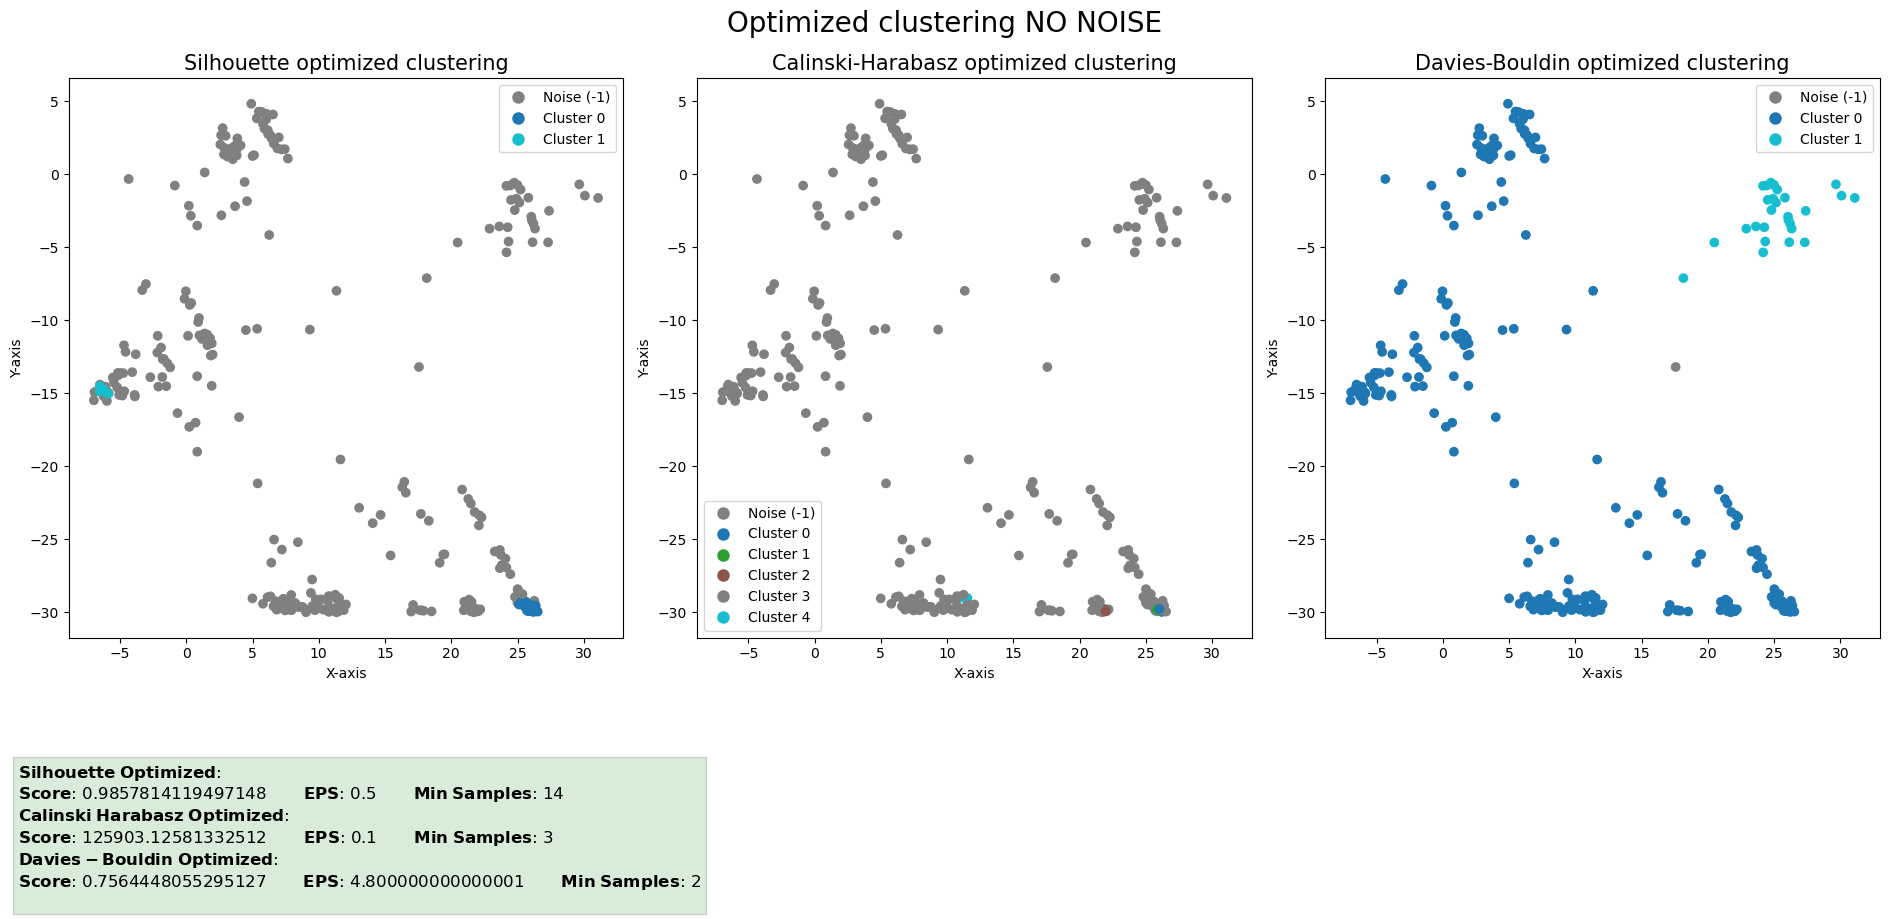

In [13]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(19, 7))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) 
ax1.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_silhouette_optimized)
ax1.set_title(f'Silhouette optimized clustering', fontsize=15)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.legend(handles=legend_handles_start_end_silhouette_optimized)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_calinski_harabasz_optimized)
ax2.set_title(f'Calinski-Harabasz optimized clustering', fontsize=15)
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.legend(handles=legend_handles_start_end_calinski_harabasz_optimized)

# Create the bottom right plot
ax3 = fig.add_subplot(gs[0, 2])  # Bottom right
ax3.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_davies_bouldin_optimized)
# ax3.text(0.5, 1.4, "End Point Clusters", fontsize=16, ha='center', transform=ax3.transAxes)
ax3.set_title(f'Davies-Bouldin optimized clustering', fontsize=15)
ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.legend(handles=legend_handles_start_end_davies_bouldin_optimized)

props = dict(boxstyle='square', facecolor='green', alpha=0.15)
fig.text(0.012,-0.3,f'{metrics_description_optimzation}', fontsize=12, bbox=props)
plt.suptitle(f'Optimized clustering NO NOISE', fontsize=20)

# Display the plots
plt.tight_layout()
plt.show()